<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

<a name="start"></a>
### Start GRASS and Create a New Project

First, we'll install GRASS:

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


In [ ]:
# !pip install rpy2==3.1.0 pandas

In [2]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu/ jammy main'
Description:
Unstable releases of Ubuntu GIS packages. These releases are more bleeding edge and while generally they should work well, they dont receive the same amount of quality assurance as our stable releases do.
More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ubuntugis-unstable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ubuntugis-unstable.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http

In [1]:
!grass --version

GRASS GIS 8.5.0dev
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.5.0dev release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


Now, we can import GRASS's Python APIs, `grass.scripts` and `grass.jupyter` into our Python environment.

In [1]:
import sys
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ask GRASS where its Python packages are to be able to run it from the notebook
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)
import grass.script as gs
import grass.jupyter as gj

With our packages imported, we can now create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 3358](https://epsg.io/32632), a projection for NC in meters.

In [14]:
gs.create_project("geomorphometry_workshop", epsg="32632")

ScriptError: Location <geomorphometry_workshop> already exists. Operation canceled.

We start a GRASS session in our new project.

In [2]:
gj.init("geomorphometry_workshop")

Alternatively, set region with g.region to the approximate bounds of a watershed near Perugia that opens into a flat plain. Also, set the resolution to 10m (same as TINItaly).

In [16]:
gs.run_command(
    "r.import",
    input="w47575_s10/w47575_s10.tif",
    output="dem",
    title="TINItaly DEM 10m"
)
print(gs.read_command("g.region", raster="dem", flags="pa"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4800050
south:      4749950
west:       749950
east:       800050
nsres:      10
ewres:      10
rows:       5010
cols:       5010
cells:      25100100



In [3]:
from IPython.display import display, Image
print(gs.read_command("g.region", raster="dem", flags="pa"))

m = gj.InteractiveMap(use_region=True)
m.add_raster("dem", opacity=0.5)
m.add_layer_control()
display(m.show())

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4800050
south:      4749950
west:       749950
east:       800050
nsres:      10
ewres:      10
rows:       5010
cols:       5010
cells:      25100100



Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [4]:
print(
    gs.read_command(
        "g.region", n=4780470, s=4774720, e=783130, w=777410, res=10, flags="pa"
    )
)

gs.run_command("r.colors", map="dem", color="elevation", flags="e")

m = gj.InteractiveMap(use_region=True)
m.add_raster("dem", opacity=0.5)
m.add_layer_control()
display(m.show())

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4780470
south:      4774720
west:       777410
east:       783130
nsres:      10
ewres:      10
rows:       575
cols:       572
cells:      328900



Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

TODO: display this data and look at a history

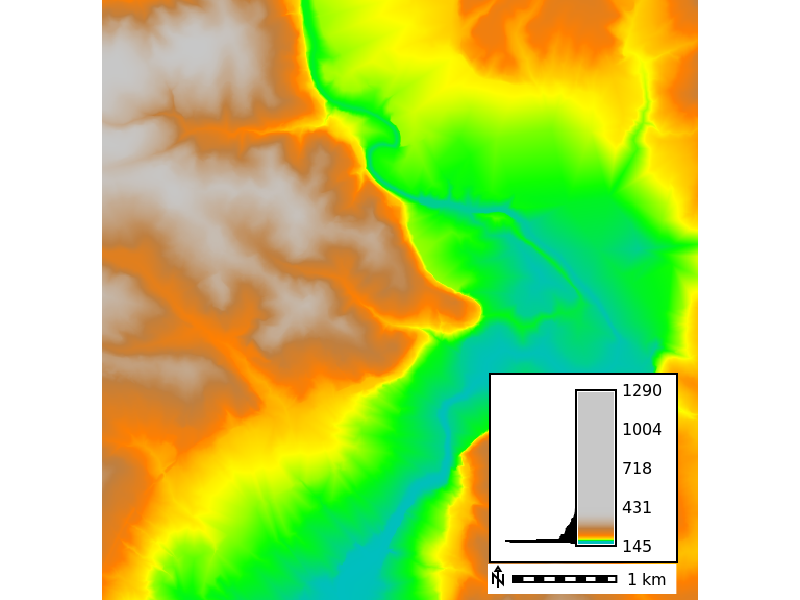

In [36]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_rast(map="dem")
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

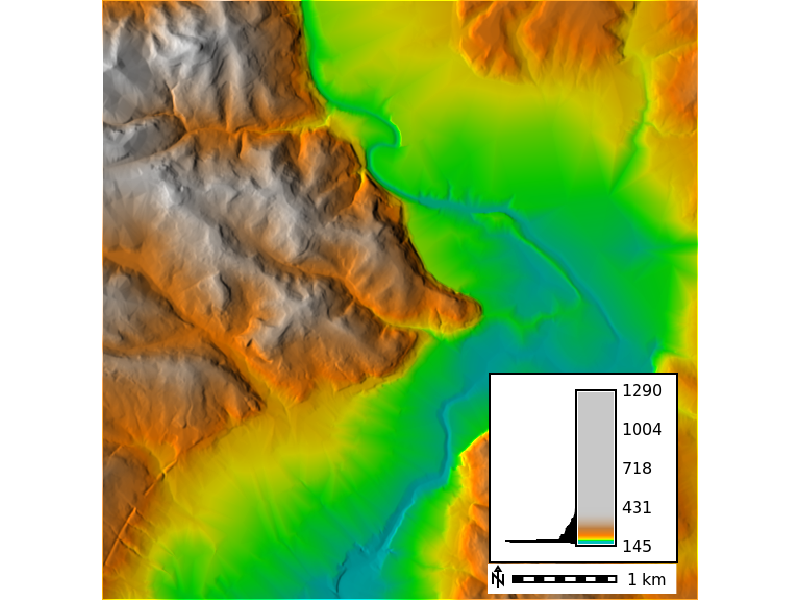

In [20]:
gs.run_command("r.relief", input="dem", output="relief")
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()


Sample Points

TODO: Statified sampling by landcover to mimic Lidar? Like lower frequency in heavily vegetated areas and none in water/buildings?

In [40]:
gs.run_command("r.random", input="dem", vector="elevrand", n=1000, flags="s")

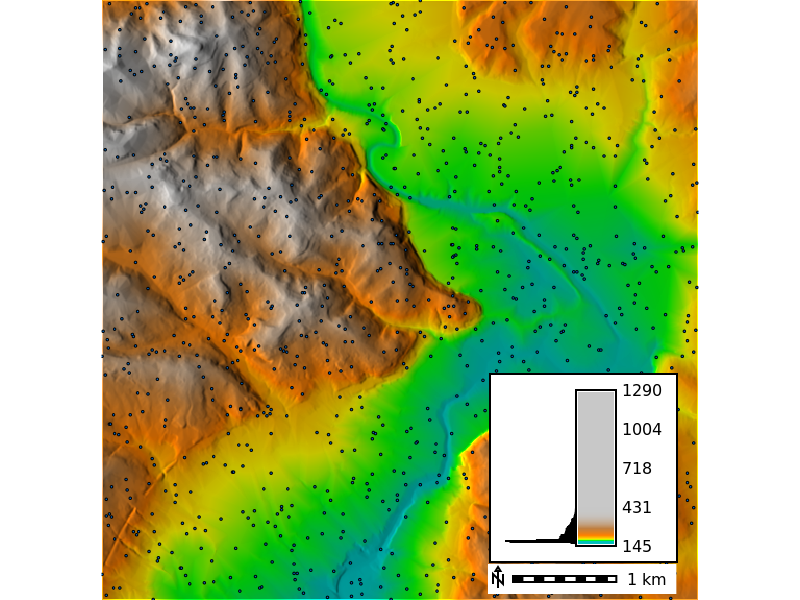

In [22]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()



In [23]:
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect", overwrite=True)

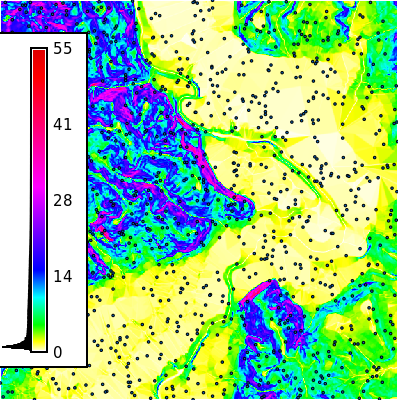

In [24]:
gs.run_command("r.colors", map="slope", color="slope")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="slope", flags="bds")
m.show()

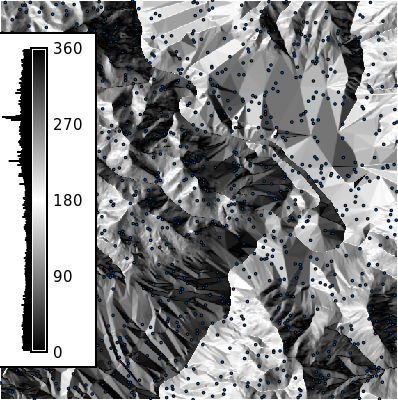

In [25]:
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="aspect", flags="bds")
m.show()

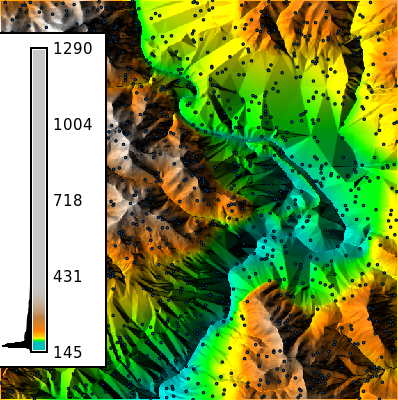

In [26]:
m = gj.Map(use_region=True)
m.d_shade(shade="aspect", color="dem", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="dem", flags="bds")
m.show()

In [44]:
from ipyleaflet import ImageService, WMSLayer

m = gj.InteractiveMap(use_region=True, map_backend="ipyleaflet", width=800, height=600)


im = ImageService(
    url='https://landsat.arcgis.com/arcgis/rest/services/Landsat/PS/ImageServer',
    rendering_rule={"rasterFunction":"Pansharpened Enhanced with DRA"},
    format='jpgpng',
    attribution='United States Geological Survey (USGS), National Aeronautics and Space Administration (NASA)'
)

# wms = WMSLayer(
#     url='http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS',
#     layers='TINItaly_1.1:tinitaly_hshd',
#     format='image/png',
#     transparent=True,
#     attribution='Elevation Data © 2023 TINItaly 1.1'
# )


m.map.add(im)
# m.map.add(wms)
m.add_raster("dem", opacity=0.5)
m.add_raster("relief", opacity=0.5)
m.add_vector("elevrand")
m.add_layer_control()
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Move to R for Kriging

Set up R.

Load rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R.

In [3]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [ ]:
%%R
system("apt-get install r-cran-sf")

In [44]:
%%R
system("apt-get install r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

We also need the rgrass package which is distributed on GitHub.

In [7]:
%%R
R.version.string
lapply(.libPaths(), list.files)
# renv::init()
# # install.packages("rgrass")
# install.packages(c("sf", "gstat", "terra", "rgrass"))

[[1]]
[1] "renv"

[[2]]
  [1] "abind"         "ape"           "backports"     "base64enc"    
  [5] "brio"          "broom"         "bslib"         "cachem"       
  [9] "callr"         "car"           "carData"       "cli"          
 [13] "colorspace"    "CompQuadForm"  "cpp11"         "crayon"       
 [17] "deldir"        "desc"          "dfoptim"       "diffobj"      
 [21] "digest"        "dplyr"         "evaluate"      "fansi"        
 [25] "farver"        "fastmap"       "fontawesome"   "fs"           
 [29] "future"        "future.apply"  "gamm4"         "geepack"      
 [33] "generics"      "getopt"        "ggplot2"       "globals"      
 [37] "glue"          "gridExtra"     "gsl"           "gtable"       
 [41] "highr"         "HSAUR3"        "htmltools"     "insight"      
 [45] "interp"        "isoband"       "jpeg"          "jquerylib"    
 [49] "jsonlite"      "knitr"         "labeling"      "latticeExtra" 
 [53] "lavaan"        "lifecycle"     "listenv"       "lme4"      

In [6]:
import rpy2.robjects.packages as rpackages

utils = rpackages.importr("utils")
base = rpackages.importr("base")
sf = rpackages.importr("sf")
gstat = rpackages.importr("gstat")
terra = rpackages.importr("terra")
rgrass = rpackages.importr("rgrass")

Load libraries.
- Tell R to use the system packages

In [6]:
%%R

library(sf)
library(gstat)
library(terra)
library(rgrass)


Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [7]:
%%R

# Set GRASS region
rgrass::execGRASS("g.region", n="4780470", s="4774720", e="783130", w="777410", flags = c("p","a"))

# Read vector elevation points from GRASS
elevrand <- rgrass::read_VECT("elevrand")

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4780470
south:      4774720
west:       777410
east:       783130
nsres:      10
ewres:      10
rows:       575
cols:       572
cells:      328900
Exporting 1000 features...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96v.out.ogr complete. 1000 features (Point type) written to <elevrand> (GPKG
format).


In [8]:
%%R
# Convert to sf-style data frame for gstat
elev_df <- terra::as.data.frame(elevrand, geom = "XY")

In [9]:
%%R
# Create gstat object
g <- gstat::gstat(formula = value ~ 1, data = elev_df, locations = ~x + y)

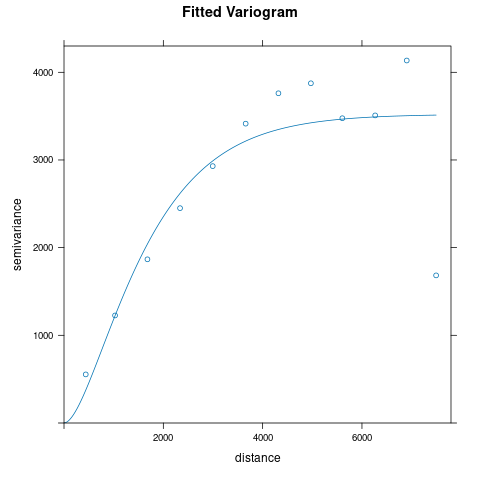

In [23]:
%%R
# Compute experimental variogram
# vg <- variogram(g, cutoff = 3000)
vg <- variogram(g, cutoff = 10000)
# Fit a model (Exponential by default; can also try Matérn via 'fit.variogram')
vfit <- gstat::fit.variogram(vg, model = gstat::vgm(model = "Mat", kappa = 1.2), fit.kappa = FALSE)

# Plot variogram and fitted model
plot(vg, model = vfit, main = "Fitted Variogram")

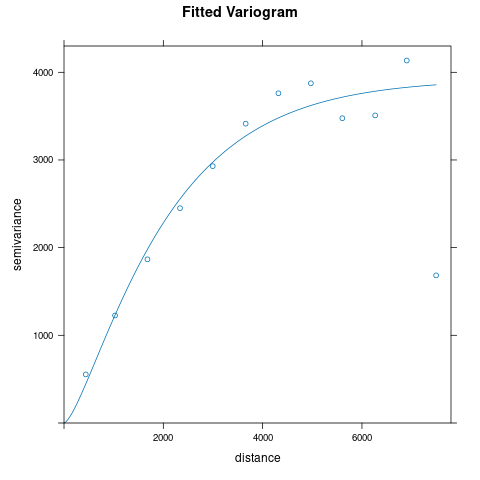

In [24]:
%%R

# Optimize the kappa parameter
f = function(x) attr(m.fit <<- fit.variogram(vg, vgm(,"Mat",nugget=NA,kappa=x)),"SSErr")
result <- optimize(f, c(0.1, 5))
vfit <- gstat::fit.variogram(vg, model = gstat::vgm(model = "Mat", kappa = result$minimum), fit.kappa = FALSE)

# Plot variogram and fitted model
plot(vg, model = vfit, main = "Fitted Variogram")

In [25]:
%%R

# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"))


# Recreate gstat object using sf
g <- gstat::gstat(formula = value ~ 1, data = elev_df, model = vfit, locations=~x+y)


In [ ]:
%%R

# Objective function: SSErr for each kappa
f <- function(kappa) {
  attr(gstat::fit.variogram(vg, gstat::vgm(model = "Mat", kappa = kappa)), "SSErr")
}

# Range of kappa values to try
kappa_vals <- seq(0.1, 5, by = 0.1)

# Compute SSErr for each value
sserr_vals <- sapply(kappa_vals, f)

# Optimize for best kappa
opt_result <- optimize(f, c(0.1, 5))
best_kappa <- opt_result$minimum
best_sserr <- opt_result$objective

# Plot SSErr vs. kappa
plot(kappa_vals, sserr_vals, type = "b", pch = 16,
     xlab = expression(kappa), ylab = "Sum of Squared Errors",
     main = "SSErr vs. Matérn Smoothness (kappa)")

# Add vertical line at best kappa
abline(v = best_kappa, col = "red", lty = 2)

# Label the optimal point
text(x = best_kappa, y = best_sserr, labels = paste0("kappa = ", round(best_kappa, 3)),
     pos = 4, col = "red")


In [27]:
%%R

z <- predict(g, newdata=xy_sf)

[using ordinary kriging]


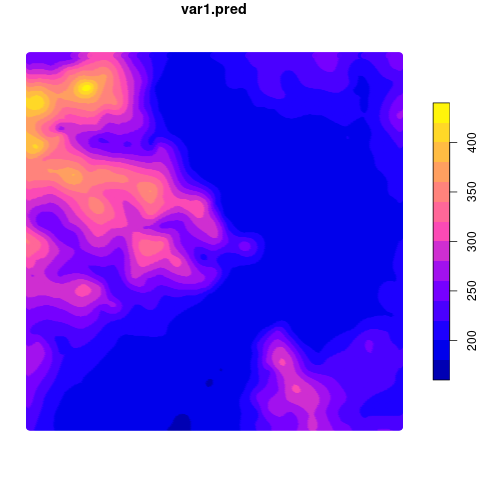

In [28]:
%%R

z_sf <- st_as_sf(z, coords = c("x", "y"), crs = crs(elevrand))

plot(z_sf["var1.pred"])

Run the stochastic simulation n times

In [ ]:
%%R
# Super slow
zsim <- predict(g, newdata=xy_sf, nsim=3)


drawing 3 GLS realisations of beta...
[using conditional Gaussian simulation]


This doesn't appear to work with rpy2. it works.

In [95]:
%%R

# Set up parallel processing
future::plan(future::multisession, workers = parallel::detectCores() - 1)

# Number of simulations
N.sim <- 10

# Perform parallel conditional simulations
sim_list <- future.apply::future_lapply(1:N.sim, function(i) {
  predict(g, newdata = xy_sp, nsim = 1)
})

# z_sim <- predict(g, newdata=xy, nsim = N.sim )

Error in UseMethod("predict") : 
  no applicable method for 'predict' applied to an object of class "c('gstat', 'list')"


RInterpreterError: Failed to parse and evaluate line '\n# Set up parallel processing\nfuture::plan(future::multisession, workers = parallel::detectCores() - 1)\n\n# Number of simulations\nN.sim <- 10\n\n# Perform parallel conditional simulations\nsim_list <- future.apply::future_lapply(1:N.sim, function(i) {\n  predict(g, newdata = xy_sp, nsim = 1)\n})\n\n# z_sim <- predict(g, newdata=xy, nsim = N.sim )\n'.
R error message: 'Error in UseMethod("predict") : \n  no applicable method for \'predict\' applied to an object of class "c(\'gstat\', \'list\')"'

Calculate the mean and standard deviation of the simulatate surfaces

In [ ]:
%%R
for(i in 1:N.sim) {writeRAST(z_sim[i], paste("simulated_", i, sep=""))}
execGRASS("g.list", type="raster", pattern="simulated_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

Generate streams for each DEM

In [ ]:
%%R
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("simulated_", i, sep=""),
 threshold=30, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Calculate the probablity and error

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

In [ ]:
%%R

r.colors simulated_mean rast=elevation_10
r.colors simulated_10 rast=elevation_10
r.colors simulated_std co=bcyr -e
r.colors aspect_10 co=aspect
r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
r.slope.aspect simulated_10 slo=slp_10 asp=asp_10
r.mapcalc "diff_spline_gsim = elevation_10 - simulated_mean"
r.colors diff_spline_gsim co=differences

In [ ]:
r.mapcalc "cleaned = if(!isnull(dtm) && isnull(dtm[-1,-1]) && isnull(dtm[-1,0]) && isnull(dtm[-1,1]) && isnull(dtm[0,-1]) && isnull(dtm[0,1]) && isnull(dtm[1,-1])  && isnull(dtm[1,0])  && isnull(dtm[1,1]), null(), dtm)"



Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html